## `All Imports`

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from scipy.stats import chi2_contingency, pointbiserialr, f_oneway
from IPython.display import display

## `Loading & Pre-processing Dataset`

In [2]:
MAIN_DATA = pd.read_csv("Electric_Vehicle_Data.csv")

# Total Rows & Rows with NaN (even single one of it)
print("Total rows:", len(MAIN_DATA))
print("Rows with NaN:", len(MAIN_DATA[MAIN_DATA.isnull().any(axis=1)]))
print(
    "\nThus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!"
)

# Dropping rows with NaN (even single one of it amongst the columns)
MAIN_DATA = MAIN_DATA.dropna()

# Printing all the total rows now
print("\nTotal rows Now:", len(MAIN_DATA))

MAIN_DATA.drop(columns=["DOL Vehicle ID", "2020 Census Tract", "Vehicle Location",
               "Legislative District", "Base MSRP", "City", "State", "Postal Code"], inplace=True)

Total rows: 181458
Rows with NaN: 403

Thus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!

Total rows Now: 181055


In [3]:
MAIN_DATA

,VIN (1-10),County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility
0,WAUTPBFF4H,King,2017,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA)
1,WAUUPBFF2J,Thurston,2018,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,16,PUGET SOUND ENERGY INC
2,5YJSA1E22H,Thurston,2017,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,PUGET SOUND ENERGY INC
3,1C4JJXP62M,Thurston,2021,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,25,PUGET SOUND ENERGY INC
4,5YJ3E1EC9L,Yakima,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,PACIFICORP
...,...,...,...,...,...,...,...,...,...
181453,50EA1TEA7P,Douglas,2023,LUCID,AIR,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,PUD NO 1 OF DOUGLAS COUNTY
181454,1C4JJXP60N,Spokane,2022,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...
181455,5YJ3E1EA0M,King,2021,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA)
181456,5YJ3E1EC8L,Clark,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...


## `Algorithms`

In [4]:
def get_unique_value_counts(data):
    """
    Compute the counts of unique values in the first column of data.

    Args:
    data (numpy.ndarray): The input data containing at least one column.

    Returns:
    list of int: A list of counts corresponding to each unique value.
    """
    unique_values, counts = np.unique(data[:, 0], return_counts=True)
    return list(counts)


def compute_buc_patterns(data, minsup):
    """
    Compute patterns with minimum support using the BUC algorithm.

    Args:
    data (numpy.ndarray): The input data as a 2D array.
    minsup (int): The minimum support threshold for patterns.

    Returns:
    pandas.DataFrame: A DataFrame containing patterns that meet the minimum support threshold.
    """
    patterns = []

    def recursive_compute(data, current_pattern=[]):
        if data.shape[1] == 0:
            patterns.append(current_pattern + [len(data)])
            return

        sorted_data = data[data[:, 0].argsort()]
        data_counts = get_unique_value_counts(sorted_data)
        i = 0

        for support in data_counts:
            if support >= minsup:
                new_pattern = current_pattern + [sorted_data[i, 0]]
                recursive_compute(sorted_data[i : i + support, 1:], new_pattern)
            i += support

        new_pattern = current_pattern + ["ALL"]
        recursive_compute(data[:, 1:], new_pattern)

    recursive_compute(data, [])

    result_df = pd.DataFrame(patterns, columns=list(MAIN_DATA.columns) + ["count_buc"])
    return result_df


min_support_threshold = 0
result_patterns_df = compute_buc_patterns(MAIN_DATA.values, min_support_threshold)

## `Regular BUC on refined Dataset (minsup = 0)`

In [5]:
print("BUC Algorithm result with minimum support 0")
result_patterns_df

BUC Algorithm result with minimum support 0


,VIN (1-10),County,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Electric Utility,count_buc
0,1C4JJXN60P,Clallam,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,1
1,1C4JJXN60P,Clallam,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21,ALL,1
2,1C4JJXN60P,Clallam,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,ALL,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,1
3,1C4JJXN60P,Clallam,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,ALL,ALL,1
4,1C4JJXN60P,Clallam,2023,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),ALL,21,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,1
...,...,...,...,...,...,...,...,...,...,...
11972383,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,PUD NO 2 OF GRANT COUNTY,585
11972384,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,PUGET SOUND ENERGY INC,36705
11972385,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),67180
11972386,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,PUGET SOUND ENERGY INC||PUD NO 1 OF WHATCOM CO...,4090


In [6]:
num_col = MAIN_DATA.shape[1]
minsup = 0
def BUC(dataFrame, begin, end):
    if end - num_col >= 0:
        return
   
    column = dataFrame.columns[end]
    count_dataFrame = dataFrame.groupby(column)[column].count().reset_index(name='count').sort_values(by='count', ascending=False)

    for i in range(len(count_dataFrame)):
        if count_dataFrame.iloc[i, 1] >= minsup:
            value = count_dataFrame.iloc[i, 0]
           
            temp_dataFrame = dataFrame.loc[dataFrame[dataFrame.columns[end]] == value, dataFrame.columns[begin:end + 1]].head(1)
            temp_dataFrame = ' ~ '.join(temp_dataFrame.iloc[0].astype(str))

            next_dataFrame = dataFrame[dataFrame[dataFrame.columns[end]] == value]
            BUC(next_dataFrame, begin, end + 1)

In [7]:
sup = []
runtime = []

for i in range(0, 1000, 100):
    minsup = i

    initialTime = time.time()
    s = 0
   
    n = 1 # Number of iterations to average on
    for idx in range(n):
        for j in range(num_col):
            BUC(MAIN_DATA, j, j)
        s += minsup
       
    finalTime = time.time()
   
    sup.append(s/n)
    runtime.append(finalTime - initialTime)

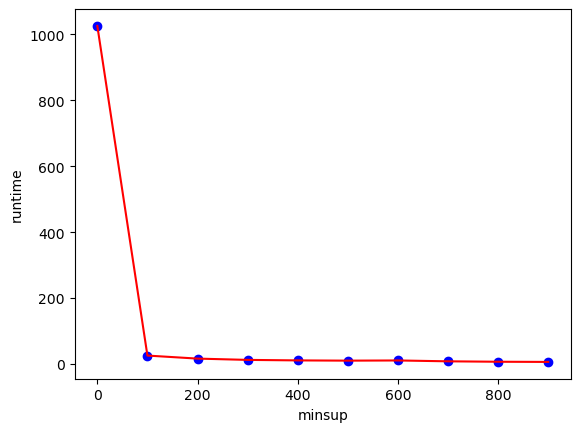

In [8]:
plt.plot(sup, runtime, color='red', linestyle='-')
plt.scatter(sup, runtime, color='blue', marker='o', label='Data Points')
plt.xlabel('minsup')
plt.ylabel('runtime')
plt.show()

In [9]:
# Calculate memory usage in KB
totalKBMemory = MAIN_DATA.memory_usage().sum() / 1024

# Change main_memory_kb from 100 to 4000 in steps of 300
# Calculate the time taken for each main_memory_kb
# Plot the graph of time vs main_memory_kb
listMemory = []
listTime = []

for mainKBMemory in range(100, 4000, 300):
    number_of_pages = int(totalKBMemory / mainKBMemory)
    initialTime = time.time()

    # Create pages and run BUC on each page
    for i in range(number_of_pages):
        dataFrame = MAIN_DATA.iloc[i * num_col:(i + 1) * num_col, :]
        for j in range(num_col):
            BUC(dataFrame, j, j)

    finalTime = time.time()
    listTime.append(finalTime - initialTime)
    listMemory.append(mainKBMemory)

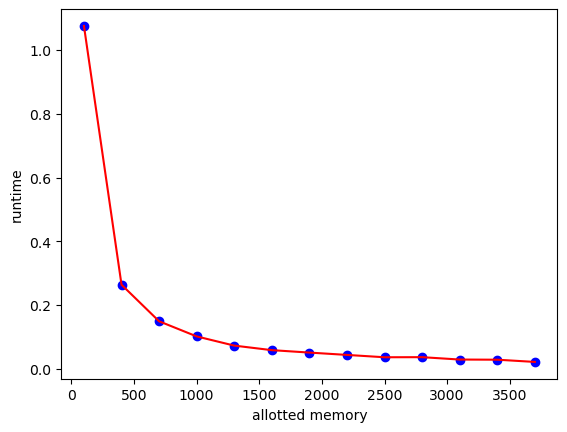

In [10]:
plt.plot(listMemory, listTime, color='red')
plt.scatter(listMemory, listTime, color='blue')
plt.xlabel('allotted memory')
plt.ylabel('runtime')
plt.show()

## `AOI v/s BUC`

### -> Primary Purposes & Use cases

__BUC Algorithm__

> * Purpose: _BUC is primarily used for creating data cubes, which are multidimensional structures that allow for the aggregation and analysis of data across various dimensions._
>
> * Use Cases: _It's often employed in OLAP (Online Analytical Processing) environments to perform complex queries, enabling insights like sales trends over time, customer segmentation, and product performance analysis across regions._


__AOI Algorithm__

> * Purpose: _AOI is used for data generalization and knowledge discovery. It helps in simplifying data by abstracting or summarizing it to higher-level concepts._
>
> * Use Cases: _AOI is typically used in data mining to extract general patterns, trends, or rules from large datasets. It’s useful in scenarios like discovering demographic patterns, market basket analysis, and behavior analysis._


### -> Insights or Patterns Each Method is Best Suited to Discover

__BUC Algorithm__

> * Patterns: _BUC excels at discovering aggregated patterns across multiple dimensions, such as total sales by product category, region, and time. It’s useful for identifying trends and outliers in large, multidimensional datasets._
>
> * Example: _BUC could identify aggregated patterns such as the average `Base MSRP` of electric vehicles across different `Brand Regions` and `Model Years`. For example, it could reveal that electric vehicles in North America have a higher average `Base MSRP` in the `2022` model year compared to other regions._

__AOI Algorithm__

> * Patterns: _AOI is suited for discovering generalized patterns, such as customer buying behavior or general trends in demographic data. It focuses on summarizing data at higher abstraction levels, making it easier to interpret and extract meaningful insights._
>
> * Exmaple: _AOI could generalize data to identify broader trends, such as summarizing the `Electric Range` of vehicles into categories (e.g., "short," "medium," "long" range). This might reveal that "long-range" vehicles are more common in certain `Brand Countries` or that `CAFV Eligible` vehicles predominantly have "medium" to "long" ranges._


### -> Computational Efficiency and Scalability

__BUC Algorithm__

> * Efficiency: _BUC is relatively efficient when dealing with sparse data cubes because it only processes non-empty cells. However, as the number of dimensions increases, the computational cost can grow exponentially._
>
> * Scalability: _BUC scales well with sparse data but can struggle with dense, high-dimensional datasets due to the exponential growth of possible aggregations._
>
> * Example: _When analyzing vehicle data across multiple dimensions like `Brand`, `Model Year`, and `Location`, BUC can efficiently handle sparse data by focusing on non-empty combinations. However, if every `Brand` has vehicles in every `Location` across all `Model Years`, the algorithm may struggle with the sheer number of combinations. If you were to add more dimensions, such as `Electric Utility` or `Cardinal Direction`, BUC could face challenges as the data cube’s size increases exponentially. This might lead to slower query times and increased computational overhead._

__AOI Algorithm__

> * Efficiency: _AOI is generally efficient because it reduces the dataset by abstracting it to higher levels, which lowers the computational complexity._
>
> * Scalability: _AOI scales well with large datasets because it simplifies the data. However, it might lose some granularity, which could be important depending on the use case._
>
> * Example: _AOI could efficiently process this dataset by generalizing attributes, such as summarizing `Base MSRP` into price categories (e.g., "low," "medium," "high"). This reduces the dataset size and complexity, making it easier to analyze broader trends. Even with additional data like new vehicle features or more granular `Location` data, AOI can scale well because it abstracts detailed information into higher-level categories, minimizing the computational burden._


### -> Interpretability of the Results

__BUC Algorithm__

> * Interpretability: _The results of BUC, typically data cubes, are highly interpretable as they provide clear, structured views of aggregated data. Users can easily drill down or roll up through dimensions to explore different levels of detail._

__AOI Algorithm__

> * Interpretability: _AOI results are also interpretable but in a different way. The generalized rules or patterns it produces are easy to understand but might be less detailed, providing a more abstract view of the data._


### Scenarios Where One Might Be Preferable Over the Other

__BUC Algorithm__

> * Scenario: _If you need to analyze the impact of `Model Year` and `Brand Region` on `Base MSRP`, BUC would allow you to drill down and explore detailed multidimensional combinations. This would be crucial if you were trying to understand specific market segments, like high-end electric vehicles in Europe over the last five years._

> * Example: _Using BUC, you could find that the `Base MSRP` for `Electric Vehicle Type` "Sedan" in `Brand Region` "Asia" has consistently been lower compared to North America for the `Model Years` 2018-2022._

__AOI Algorithm__

> * Scenario: _AOI is ideal if you want to extract general patterns, such as understanding which `Brand Countries` are more likely to produce `CAFV Eligible` vehicles. This would be useful for generating high-level business strategies or market predictions._

> * Example: _With AOI, you might discover that "European brands are more likely to produce `CAFV Eligible` vehicles with a `Base MSRP` in the 'high' category," giving you a broad understanding of market positioning without delving into granular details._